## **FINM 32000 - HW4**

#### Yumeng Zhang (12372205)

I discussed with Yitong Li and Qianyu Pan.

In [2]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Problem 1

##### **(a)**

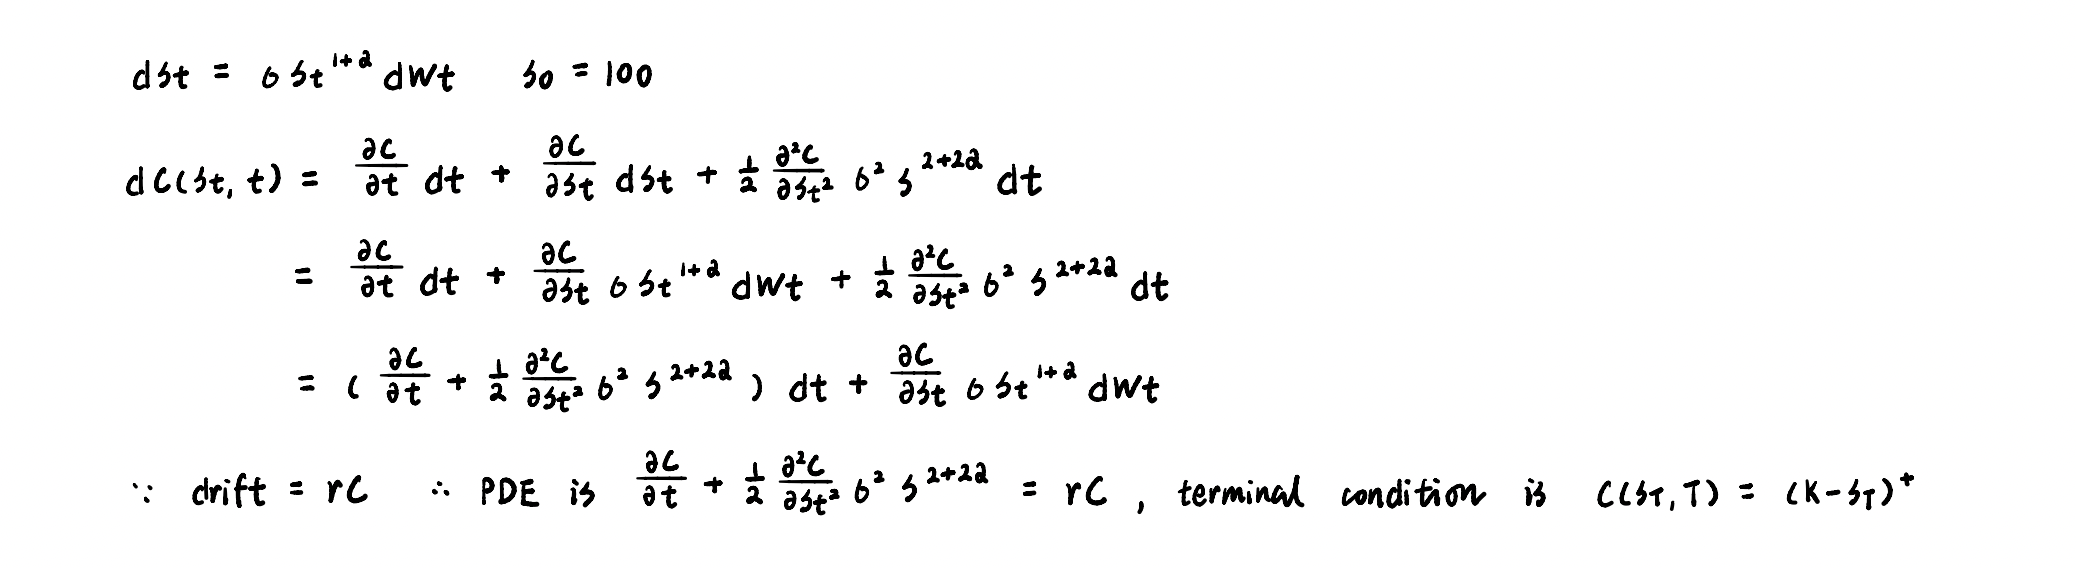

##### **(b)**

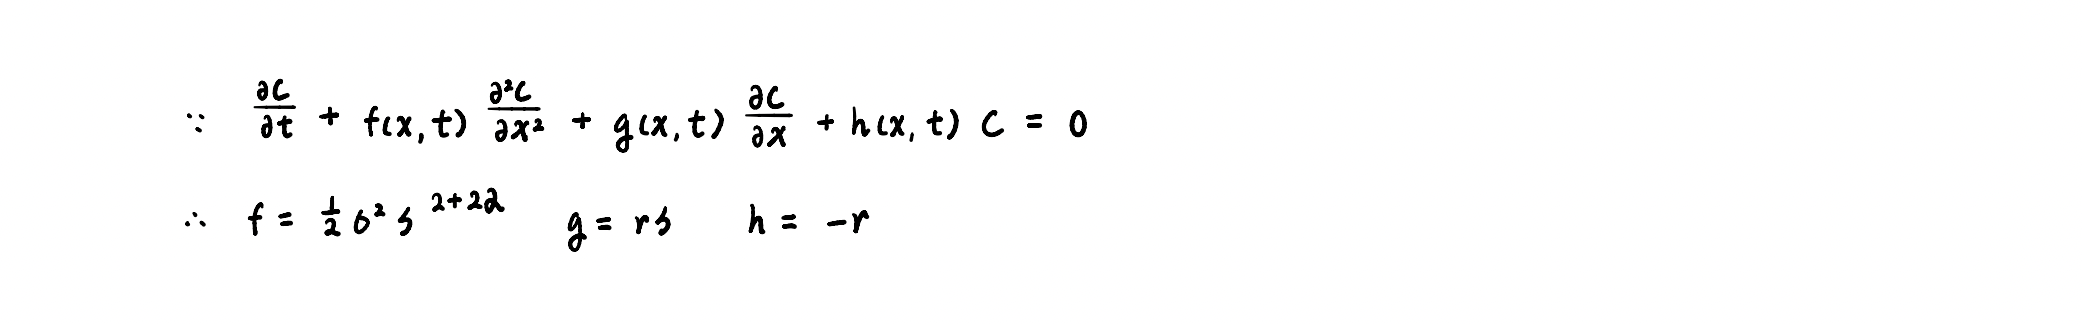

In [3]:
class CEV:
    
    def __init__(self,volcoeff,alpha,rGrow,r,S0):
        self.volcoeff = volcoeff
        self.alpha = alpha
        self.rGrow = rGrow  
        self.r = r
        self.S0 = S0


In [4]:
hw4dynamics = CEV(volcoeff=3, alpha=-0.5, rGrow=0, r=0.05, S0=100)

In [5]:
class Put:
    
    def __init__(self,T,K):
        self.T = T;
        self.K = K;

In [6]:
hw4contract=Put(T=0.25,K=100)

In [7]:
class FD_CrankNicolson:
    
    def __init__(self,SMax,SMin,deltaS,deltat):
        self.SMax=SMax
        self.SMin=SMin
        self.deltaS=deltaS
        self.deltat=deltat        
        
        
    #You complete the coding of this function:
        
    def price_put_CEV(self,contract,dynamics):
    # returns array of all initial spots,
    # and the corresponding array of put prices

        alpha, r, rGrow, volcoeff = dynamics.alpha, dynamics.r, dynamics.rGrow, dynamics.volcoeff 

        # SMin and SMax denote the smallest and largest S in the _interior_.
        # The boundary conditions are imposed one level _beyond_, 
        # e.g. at S_lowboundary=SMin-deltaS, not at SMin.
        # To relate to lecture notation, S_lowboundary is S_{-J}
        # whereas SMin is S_{-J+1}

        N=round(contract.T/self.deltat)
        if abs(N-contract.T/self.deltat)>1e-12:
            raise ValueError('Bad time step')
        numS=round((self.SMax-self.SMin)/self.deltaS)+1
        if abs(numS-(self.SMax-self.SMin)/self.deltaS-1)>1e-12:
            raise ValueError('Bad time step')
        S=np.linspace(self.SMax,self.SMin,numS)    #The FIRST indices in this array are for HIGH levels of S
        S_lowboundary=self.SMin-self.deltaS

        putprice=np.maximum(contract.K-S,0)

        ratio1 = self.deltat/self.deltaS
        ratio2 = self.deltat/self.deltaS**2
        f = 0.5*(volcoeff**2)*(S**(2+2*alpha))   # You fill in with an array of the same size as S.
        g = rGrow*S   # You fill in with an array of the same size as S.
        h = (-1)*r   # You fill in with an array of the same size as S (or a scalar is acceptable here)
        F = 0.5*ratio2*f + 0.25*ratio1*g
        G = ratio2*f - 0.50*self.deltat*h
        H = 0.5*ratio2*f - 0.25*ratio1*g

        #Right-hand-side matrix
        RHSmatrix = diags([H[:-1], 1-G, F[1:]], [1,0,-1], shape=(numS,numS), format="csr")

        #Left-hand-side matrix
        LHSmatrix = diags([-H[:-1], 1+G, -F[1:]], [1,0,-1], shape=(numS,numS), format="csr")
        # diags creates SPARSE matrices

        for t in np.arange(N-1,-1,-1)*self.deltat:

            rhs = RHSmatrix * putprice

            #Now let's add the boundary condition vectors.
            #They are nonzero only in the last component:
            rhs[-1]=rhs[-1]+2*H[-1]*(contract.K-S_lowboundary)

            putprice = spsolve(LHSmatrix, rhs)
            # You code this.  Hint...
            # numpy.linalg.solve, which expects arrays as inputs,
            # is fine for small matrix equations, and for matrix equations without special structure.
            # But for large matrix equations in which the matrix has special structure,
            # we may want a more intelligent solver that can run faster 
            # by taking advantage of the special structure of the matrix.
            # Specifically, in this case, let's try to use a solver that recognizes the SPARSE MATRIX structure.
            # Try spsolve, imported from scipy.sparse.linalg
            
            putprice = np.maximum(putprice, contract.K-S)

        return(S, putprice)

In [8]:
hw4FD = FD_CrankNicolson(SMax=200,SMin=50,deltaS=0.1,deltat=0.0005)

In [9]:
(S0_all, putprice) = hw4FD.price_put_CEV(hw4contract,hw4dynamics)

In [10]:
# pricer_put_CEV_CrankNicolson gives us option prices for ALL S0 from SMin to SMax
# But let's display only for a few S0 near 100:

displayStart = hw4dynamics.S0-hw4FD.deltaS*1.5 
displayEnd   = hw4dynamics.S0+hw4FD.deltaS*1.5
displayrows  = (S0_all>displayStart) & (S0_all<displayEnd)
np.set_printoptions(precision=4, suppress=True)
print(np.stack((S0_all, putprice),axis=1)[displayrows])

[[100.1      5.8704]
 [100.       5.9183]
 [ 99.9      5.9665]]


##### **(c)**

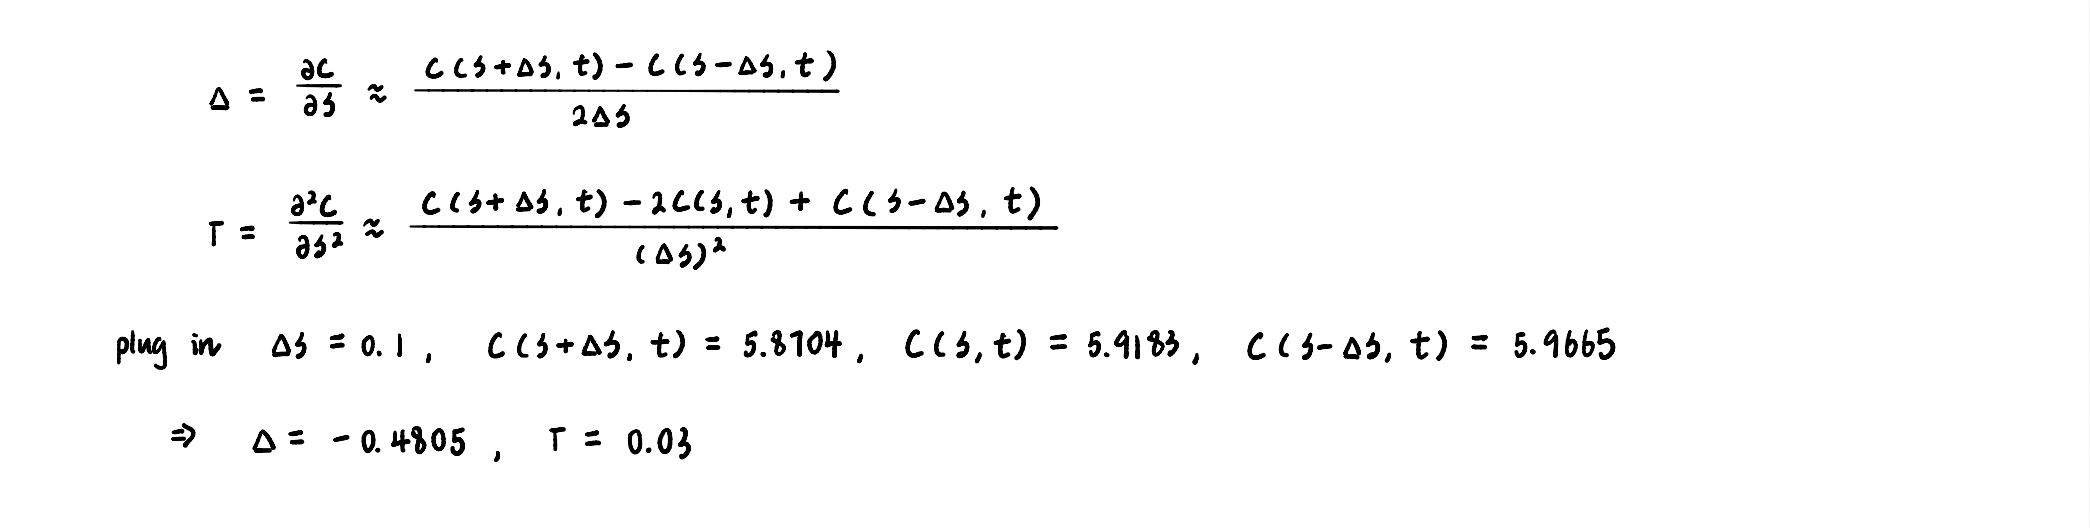

##### **(d)**

In [11]:
hw4dynamics2 = CEV(volcoeff=0.3, alpha=0, rGrow=0.05, r=0.05, S0=100)

(S0_all, putprice) = hw4FD.price_put_CEV(hw4contract,hw4dynamics2)

displayStart = hw4dynamics2.S0-hw4FD.deltaS*1.5 
displayEnd   = hw4dynamics2.S0+hw4FD.deltaS*1.5
displayrows  = (S0_all>displayStart) & (S0_all<displayEnd)
np.set_printoptions(precision=4, suppress=True)
print(np.stack((S0_all, putprice),axis=1)[displayrows])

[[100.1      5.3973]
 [100.       5.442 ]
 [ 99.9      5.487 ]]


# Problem 2

##### **(a)**

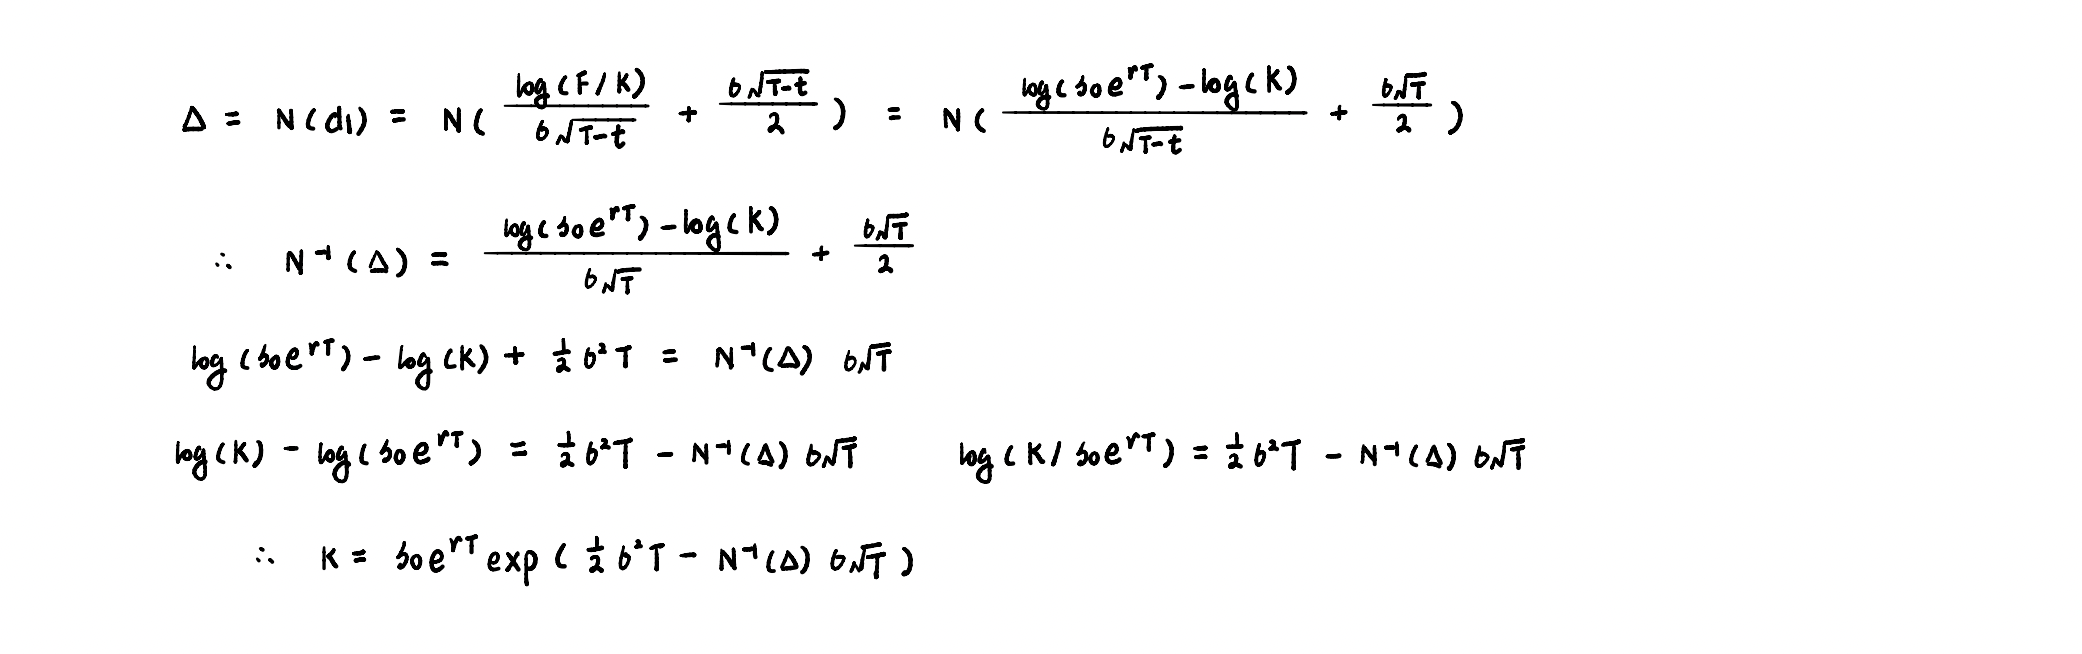

##### **(b)**

In [18]:
from scipy.stats import norm

def BS_call(S, K, T, r, sigma):

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return price

def calculate_K(S, T, r, sigma, delta):

    K = S * np.exp(r*T) * np.exp(0.5*T*(sigma**2)-norm.ppf(delta)*sigma*np.sqrt(T))

    return K

In [19]:
S0 = 300
T = 1/12
sigma = 0.4
r = 0.01

In [27]:
# 25-delta

delta1 = 0.25

K1 = calculate_K(S0, T, r, sigma, delta1)
price1 = BS_call(S0, K1, T, r, sigma)

print("The strike of a 25-delta call is "+ str(round(K1,4)) + ", the premium is "+ str(round(price1,4))+ ".")

The strike of a 25-delta call is 326.7404, the premium is 4.8826.


In [28]:
# 75-delta

delta2 = 0.75

K2 = calculate_K(S0, T, r, sigma, delta2)
price2 = BS_call(S0, K2, T, r, sigma)

print("The strike of a 75-delta call is "+ str(round(K2,4)) + ", the premium is "+ str(round(price2,4))+ ".")

The strike of a 75-delta call is 279.6109, the premium is 26.1036.


##### **(c)**

In [26]:
def calculate_lambda(delta, S, C):

    lambda_ = delta*S/C
    
    return lambda_

In [30]:
# 25-delta

lambda1 = calculate_lambda(delta1, S0, price1)
print("The lambda of the 25-delta call is "+ str(round(lambda1,4)) + ".")

The lambda of the 25-delta call is 15.3607.


In [31]:
# 75-delta

lambda2 = calculate_lambda(delta2, S0, price2)
print("The lambda of the 75-delta call is "+ str(round(lambda2,4)) + ".")

The lambda of the 75-delta call is 8.6195.


The 25-delta call gives more leverage。